In [208]:
from __future__ import division
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from nltk.probability import FreqDist as FreqDist  
from numpy.polynomial.polynomial import polyfit
from collections import Counter
from string import digits
from scipy import stats
import operator
from collections import OrderedDict

In [209]:
def get_sentences(num_sentences):
    sentences= brown.sents()[:num_sentences]
    ret=[]
    for sentence in sentences:
        ret.append(' '.join(sentence))
    return ret

In [210]:
def preprocess_sents(sentences):
    sentences = [sentence.lower() for sentence in sentences]
    remove_digits = str.maketrans('', '', digits)
    sentences = [sentence.translate(remove_digits)  for sentence in sentences]
    sentences=[re.sub('\W+',' ', sentence) for sentence in sentences]
    return sentences

In [211]:
def plot(x,y,Title=''):
    x=np.asarray(x)
    y=np.asarray(y)
    #slope, intercept=polyfit(x, y, 1)
    #plt.plot(x, intercept + slope*x, 'r', label='fitted line')
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),'r', label='fitted line')
    plt.plot(x,y,label='original data')
    plt.title(Title)
    plt.legend()
    plt.show()

In [212]:
def unigram_LM(sents):
    unigrams=[]
    for elem in sents:
        unigrams.extend(elem.split())

    unigram_counts=Counter(unigrams)
    unique_unigrams=set(unigrams)
    unigram_total=len(unigrams)
    unigram_freq=dict()
    for word in unigram_counts:
        unigram_freq[word]=unigram_counts[word]/unigram_total

    unigram_counts['<s>']=len(sents)

    return unigram_counts,unigram_freq,unigram_total

In [213]:
def bigram_model(sentences,k=0,unique_bigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2 in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if w1 not in model:
                model[w1]={}
            if w2 not in model[w1]:
                model[w1][w2]=0
            model[w1][w2]+=1
    for w1 in model:
        tot_count=float(sum(model[w1].values()))
        for w2 in model[w1]:
            model[w1][w2]+=k
            model[w1][w2]/=(tot_count+k*unique_bigrams_num)
     
    return model



In [214]:
def trigram_model(sentences=0,k=0,unique_trigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2,w3 in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if (w1,w2) not in model:
                model[(w1,w2)]={}
            if w3 not in model[(w1,w2)]:
                model[(w1,w2)][w3]=0
            model[(w1,w2)][w3]+=1
    for (w1,w2) in model:
        tot_count=float(sum(model[(w1,w2)].values()))
        for w3 in model[(w1,w2)]:
            model[(w1,w2)][w3]+=k
            model[(w1,w2)][w3]/=(tot_count+k*unique_trigrams_num)
     
    return model


In [215]:
def get_test_sentences(filename='test_examples.txt'):
    sents=list()
    with open(filename,'r') as f:
        for line in f:
            sents.append(line)
        f.close()
    return preprocess_sents(sents)

In [216]:
def laplacian_unigram_model(w1,unigram_counts,k,N):
    V=len(unigram_counts)
    return np.log( ( (k+unigram_counts.get(w1,0))/(k*V+N) )  )
def laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V):
    return np.log( ( (k+bigram_counts.get((w1,w2),0))/(k*V+unigram_counts.get(w1,0)) )  )

def laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k):
    return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*V+bigram_counts.get((w1,w2),0)) )  )

### Getting the sentences from the Brown corpus

In [217]:
sents=get_sentences(40000)            # Get 40k sentences from the Brown corpus as mentioned in assignment
sents=preprocess_sents(sents)

In [218]:
for sent in sents[:10]:
    print(sent)

the fulton county grand jury said friday an investigation of atlanta s recent primary election produced no evidence that any irregularities took place 
the jury further said in term end presentments that the city executive committee which had over all charge of the election deserves the praise and thanks of the city of atlanta for the manner in which the election was conducted 
the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible irregularities in the hard fought primary which was won by mayor nominate ivan allen jr 
 only a relative handful of such reports was received the jury said considering the widespread interest in the election the number of voters and the size of this city 
the jury said it did find that many of georgia s registration and election laws are outmoded or inadequate and often ambiguous 
it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing

## Creating the Language Models

In [219]:
unigram_counts,unigram_freq,unigram_total=unigram_LM(sents)
bigram_LM= bigram_model(sents)
trigram_LM= trigram_model(sents)

## Verifying Zipf's Law

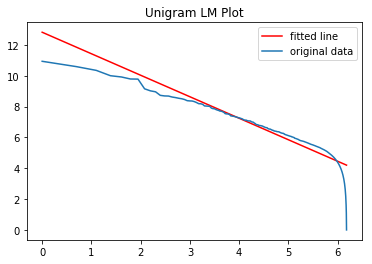

In [220]:
lis=[y[1] for y in unigram_counts.most_common()]
lis=np.flip(np.unique(lis),0)
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Unigram LM Plot')
sorted_unigram_counts=sorted(unigram_counts.items(), key=operator.itemgetter(1),reverse=True)

In [221]:
bigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in bigram_counts):
            bigram_counts[w]=1
        else:
            bigram_counts[w]+=1


sorted_bigram_counts=sorted(bigram_counts.items(), key=operator.itemgetter(1),reverse=True)

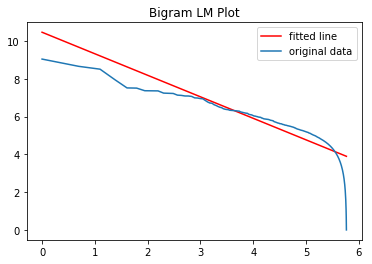

In [222]:
len_bigrams=len(sorted_bigram_counts)
lis=[y[1] for y in sorted_bigram_counts]
lis=np.flip(np.unique(lis),0)
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Bigram LM Plot')

In [223]:
np.log(lis)

array([9.04923221, 8.66526831, 8.51438926, 7.94449216, 7.52185925,
       7.51152465, 7.37274637, 7.36833969, 7.3639135 , 7.24636808,
       7.23705903, 7.2276625 , 7.13966034, 7.12528309, 7.09423485,
       7.09340463, 7.07157336, 6.99484999, 6.98656646, 6.95844839,
       6.94505106, 6.86275791, 6.7787849 , 6.72262979, 6.70930434,
       6.63200178, 6.59167373, 6.53958596, 6.49828215, 6.47543272,
       6.41999493, 6.39359075, 6.37842618, 6.36990098, 6.33859408,
       6.33327963, 6.32972091, 6.31896811, 6.31173481, 6.30991828,
       6.29894925, 6.28971557, 6.24997524, 6.23441073, 6.21860012,
       6.19847872, 6.19031541, 6.18208491, 6.1737861 , 6.13122649,
       6.11146734, 6.10479323, 6.09356977, 6.06842559, 6.04500531,
       6.03068526, 6.02586597, 6.00881319, 6.00141488, 5.98141421,
       5.97380961, 5.97126184, 5.96100534, 5.92692603, 5.92157842,
       5.89715387, 5.88332239, 5.87773578, 5.87493073, 5.86363118,
       5.86078622, 5.85793315, 5.84932478, 5.83773045, 5.82304

In [224]:
trigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in trigram_counts):
            trigram_counts[w]=1
        else:
            trigram_counts[w]+=1



sorted_trigram_counts=sorted(trigram_counts.items(), key=operator.itemgetter(1),reverse=True)

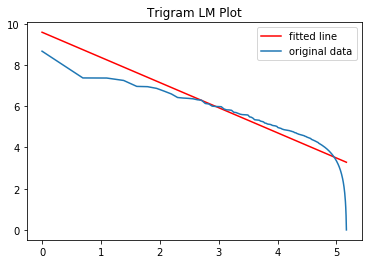

In [225]:
lis=[y[1] for y in sorted_trigram_counts]
lis=np.flip(np.unique(lis),0)
x=[np.log(i+1) for i in range(len(lis))]
y=np.asarray(list(np.log(y) for y in lis))
plot(x,y,'Trigram LM Plot')

In [226]:
sorted_unigram_counts[:11]

[('the', 56474),
 ('<s>', 40000),
 ('of', 31329),
 ('and', 22154),
 ('to', 20413),
 ('a', 17918),
 ('in', 17766),
 ('is', 9474),
 ('that', 8306),
 ('for', 7797),
 ('it', 6198)]

In [227]:
sorted_bigram_counts[:10]

[(('of', 'the'), 8512),
 (('<s>', 'the'), 5798),
 (('in', 'the'), 4986),
 (('to', 'the'), 2820),
 (('and', 'the'), 1848),
 (('on', 'the'), 1829),
 (('for', 'the'), 1592),
 (('<s>', 'in'), 1585),
 (('<s>', 'it'), 1578),
 (('<s>', 'he'), 1403)]

In [228]:
sorted_trigram_counts[:10]

[(('<s>', '<s>', 'the'), 5798),
 (('<s>', '<s>', 'in'), 1585),
 (('<s>', '<s>', 'it'), 1578),
 (('<s>', '<s>', 'he'), 1403),
 (('<s>', '<s>', 'this'), 1052),
 (('<s>', '<s>', 'but'), 1038),
 (('<s>', '<s>', 'a'), 956),
 (('<s>', '<s>', 'and'), 831),
 (('<s>', '<s>', 'i'), 729),
 (('<s>', '<s>', 'they'), 614)]

## Testing (without smoothing)

In [229]:
test_sents=get_test_sentences()

In [230]:
test_unigram_arr=[]
print('Unigram test probabilities: ')
print()
for sent in test_sents:
    try:
        p_val=np.sum([np.log(unigram_freq[word]) for word in sent.split()])
    except Exception as e:
        p_val=-np.inf
    test_unigram_arr.append(p_val)
    print('The sequence \"'+sent+' \" has unigram probablity of '+ str(p_val))


Unigram test probabilities: 

The sequence "he lived a good life  " has unigram probablity of -32.61637181331728
The sequence "the man was happy  " has unigram probablity of -23.897270970344053
The sequence "the person was good  " has unigram probablity of -23.326684213898012
The sequence "the girl was sad  " has unigram probablity of -27.222336320670067
The sequence "he won the war " has unigram probablity of -24.106951714822433


In [231]:
test_bigram_arr=[]
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if w1 in bigram_LM:
            try:
                p_val+=np.log(bigram_LM[w1][w2])
            except Exception as e:
                p_val=-np.inf
                break
        else:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
    test_bigram_arr.append(p_val)

The sequence "he lived a good life " has bigram probablity of -26.88656843222555
The sequence "the man was happy " has bigram probablity of -22.06160121911623
The sequence "the person was good " has bigram probablity of -24.839981504247724
The sequence "the girl was sad " has bigram probablity of -inf
The sequence "he won the war" has bigram probablity of -20.079546963054263


In [232]:
test_trigram_arr=[]
print('Trigram test probabilities: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            p_val+=np.log(trigram_LM[(w1,w2)][w3])
        except Exception as e:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))
    
    test_trigram_arr.append(p_val)

Trigram test probabilities: 
The sequence "he lived a good life " has trigram probablity of -inf
The sequence "the man was happy " has trigram probablity of -inf
The sequence "the person was good " has trigram probablity of -inf
The sequence "the girl was sad " has trigram probablity of -inf
The sequence "he won the war" has trigram probablity of -16.519106408717104


## Laplace/ Additive Smoothing

In [233]:
k_list=[pow(10,i) for i in range(-4,1)]
V=len(unigram_counts.values())

In [234]:
test_uniigram_arr=[]
for k in k_list:
    print('Unigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1 in sent.split():
            p_val+=laplacian_unigram_model(w1,unigram_counts,k,unigram_total)
        print('The sequence \"'+ sent +'\" has unigram probablity of '+ str(p_val))
        test_unigram_arr.append(p_val)
    print("\n")
    

Unigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has unigram probablity of -32.61639313195372
The sequence "the man was happy " has unigram probablity of -23.897287718682307
The sequence "the person was good " has unigram probablity of -23.326701919843288
The sequence "the girl was sad " has unigram probablity of -27.222348042217277
The sequence "he won the war" has unigram probablity of -24.10696910636703


Unigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has unigram probablity of -32.616584994926185
The sequence "the man was happy " has unigram probablity of -23.897438449963843
The sequence "the person was good " has unigram probablity of -23.32686126947842
The sequence "the girl was sad " has unigram probablity of -27.222453533846164
The sequence "he won the war" has unigram probablity of -24.107125626415982


Unigram test probabilities with La

In [235]:
test_bigram_arr=[]
for k in k_list:

    print('Bigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,V)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 
The sequence "he lived a good life " has bigram probablity of -26.956115844462982
The sequence "the man was happy " has bigram probablity of -22.128016928486232
The sequence "the person was good " has bigram probablity of -24.87279365929685
The sequence "the girl was sad " has bigram probablity of -34.43170756838363
The sequence "he won the war" has bigram probablity of -20.123700434271637


Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 
The sequence "he lived a good life " has bigram probablity of -27.471899994710714
The sequence "the man was happy " has bigram probablity of -22.601935867047906
The sequence "the person was good " has bigram probablity of -25.13996877695201
The sequence "the girl was sad " has bigram probablity of -33.362882449445124
The sequence "he won the war" has bigram probablity of -20.472866918268032


Bigram test probabilities with Laplacian/ Additi

In [236]:
for k in k_list:
    test_trigram_arr=[]
    print('Trigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k)
        print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))

        test_trigram_arr.append(p_val)
    print("\n")

Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has trigram probablity of -38.40914951768351
The sequence "the man was happy " has trigram probablity of -25.15853260252775
The sequence "the person was good " has trigram probablity of -25.449195019067126
The sequence "the girl was sad " has trigram probablity of -26.664911149636378
The sequence "he won the war" has trigram probablity of -7.9230750719253775


Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has trigram probablity of -39.89600612730909
The sequence "the man was happy " has trigram probablity of -27.38527004305969
The sequence "the person was good " has trigram probablity of -28.342864982279387
The sequence "the girl was sad " has trigram probablity of -31.56188900404047
The sequence "he won the war" has trigram probablity of -13.309857198931738


Trigram test probabilities with Lapl

## Interpolation Models

In [237]:
def interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts):
    num_unigrams=len(unigram_counts.values())
    if (w1 in unigram_counts):
        probability= Lambda*((bigram_counts.get((w1,w2),0))/(unigram_counts.get(w1,0))) +(1-Lambda)*(unigram_counts.get(w2,0)/num_unigrams)
    else:
        print(w1)
        return -np.inf
    if(probability==0):
        return -np.inf
    else:
        return np.log(probability)

In [238]:
test_bigram_arr=[]
lambda_list=[0.2, 0.5, 0.8]
num_unique_bigrams=len(bigram_counts.values())
for Lambda in lambda_list:

    print('Bigram test probabilities with Interpolation with lambda as',Lambda,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Interpolation with lambda as 0.2 : 
The sequence "he lived a good life " has bigram probablity of -21.22206613167789
The sequence "the man was happy " has bigram probablity of -16.0985514676804
The sequence "the person was good " has bigram probablity of -16.218514874415803
The sequence "the girl was sad " has bigram probablity of -19.51848178080951
The sequence "he won the war" has bigram probablity of -15.807276922168901


Bigram test probabilities with Interpolation with lambda as 0.5 : 
The sequence "he lived a good life " has bigram probablity of -21.70829104486406
The sequence "the man was happy " has bigram probablity of -16.666814503643206
The sequence "the person was good " has bigram probablity of -16.98712336693744
The sequence "the girl was sad " has bigram probablity of -20.266873101374973
The sequence "he won the war" has bigram probablity of -16.151138693025025


Bigram test probabilities with Interpolation with lambda as 0.8 : 
The sequenc

# Good Turing Smoothing

In [249]:
def  build_N_counts_bigram(language_model):
    global N_counts_bigram
    global N_bigram
    for key,value in language_model.items():
        if value not in N_counts_bigram:
            N_counts_bigram[value]=1
        else:
            N_counts_bigram[value]+=1
    #N_counts_bigram[0]=V*V-(len(language_model.keys()))            # Bigrams not seen

    for key,value in N_counts_bigram.items():                      # Total number of bigrams
        N_bigram+=(key*value)
        
def  build_N_counts_trigram(language_model):
    global N_counts_trigram
    global N_trigram
    for key,value in language_model.items():
        if value not in N_counts_trigram:
            N_counts_trigram[value]=1
        else:
            N_counts_trigram[value]+=1

    #N_counts_trigram[0]=V*V*V-(len(language_model.keys()))          # Trigrams not seen
    N_trigram=0
    for key,value in N_counts_trigram.items():                      # Total number of trigrams
        N_trigram+=(key*value)
        
def P_GT_bigram(language_model,k,w1,w2):        # Returns Good-Turing smoothed probability for the bigrams (w1,w2)
    r=language_model.get((w1,w2),0)
    if(r==0):
        return(N_counts_bigram[1]/N_bigram)     # return (N1/N) for unseen words
    elif(r>k):
        return (r/N_bigram)
    else:
        numerator_first=(r+1)*(N_counts_bigram[r+1]/N_counts_bigram[r])
        numerator_second=r*(k+1)*(N_counts_bigram[k+1]/N_counts_bigram[1])
        denominator=1-((k+1)*(N_counts_bigram[k+1]/N_counts_bigram[1]))
        r_star=(numerator_first-numerator_second)/denominator
        return (r_star/N_bigram)
        
        
def P_GT_trigram(language_model,k,w1,w2,w3):  #Returns Good-Turing smoothed probability for the trigrams (w1,w2,w3)
    r=language_model.get((w1,w2,w3),0)
    if(r==0):
        return(N_counts_trigram[1]/N_trigram)   # return (N1/N) for unseen words
    elif(r>k):
        return (r/N_trigram)

    else:
        numerator_first=(r+1)*(N_counts_trigram[r+1]/N_counts_trigram[r])
        numerator_second=r*(k+1)*(N_counts_trigram[k+1]/N_counts_trigram[1])
        denominator=1-((k+1)*(N_counts_trigram[k+1]/N_counts_trigram[1]))
        r_star=(numerator_first-numerator_second)/denominator
        return(r_star/N_trigram)

In [272]:
N_counts_bigram=dict()
N_bigram=0
build_N_counts_bigram(bigram_counts)
N_counts_trigram=dict()
N_trigram=0

In [273]:
unigram_freq['<s>']=unigram_counts['<s>']/V
test_bigram_arr=[]
k=10
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        p_val+=np.log(P_GT_bigram(bigram_counts,k,w1,w2)/unigram_freq[w1])
    print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
    test_bigram_arr.append(p_val)

The sequence "he lived a good life " has bigram probablity of -32.9985145839402
The sequence "the man was happy " has bigram probablity of -25.8893832190094
The sequence "the person was good " has bigram probablity of -29.720399667427202
The sequence "the girl was sad " has bigram probablity of -16.94131348478619
The sequence "he won the war" has bigram probablity of -23.59871617200846


In [278]:
build_N_counts_trigram(trigram_counts)
bigram_counts[('<s>','<s>')]=unigram_counts['<s>']

In [256]:
test_trigram_arr=[]
print('Trigram test probabilities: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        p_val+=np.log(P_GT_trigram(trigram_counts,k,w1,w2,w3)/P_GT_bigram(bigram_counts,k,w1,w2))
        print(P_GT_trigram(trigram_counts,k,w1,w2,w3),P_GT_bigram(bigram_counts,k,w1,w2),w1,w2,w3)
    print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))
    
    test_trigram_arr.append(p_val)
del(bigram_counts[('<s>','<s>')])

Trigram test probabilities: 
0.0016173898808803304 0.31766989305659454 <s> <s> he
2.0653232648451395e-06 0.0016955768768271563 <s> he lived
0.6789429210084305 6.040038044232546e-06 he lived a
0.6789429210084305 3.5343281445008287e-07 lived a good
1.471094963899047e-07 0.00021391098160969827 a good life
0.6789429210084305 3.5343281445008287e-07 good life </s>
0.000134878557421952 0.00014139878445386834 life </s> </s>
The sequence "he lived a good life " has trigram probablity of 21.246552389791635
0.006683981845576733 0.31766989305659454 <s> <s> the
1.4943574978328688e-05 0.007007095318491698 <s> the man
4.365212421792467e-06 0.00011964512530711937 the man was
0.6789429210084305 1.461866285285337e-05 man was happy
0.6789429210084305 2.493193022283574e-06 was happy </s>
6.66156759968681e-06 7.458978310860495e-06 happy </s> </s>
The sequence "the man was happy " has trigram probablity of 9.825098657451676
0.006683981845576733 0.31766989305659454 <s> <s> the
2.0653232648451395e-06 0.007007

KeyError: ('<s>', '<s>')

In [189]:
sorted_trigram_counts[]

[(('<s>', '<s>', 'the'), 5798),
 (('<s>', '<s>', 'in'), 1585),
 (('<s>', '<s>', 'it'), 1578),
 (('<s>', '<s>', 'he'), 1403),
 (('<s>', '<s>', 'this'), 1052),
 (('<s>', '<s>', 'but'), 1038),
 (('<s>', '<s>', 'a'), 956),
 (('<s>', '<s>', 'and'), 831),
 (('<s>', '<s>', 'i'), 729),
 (('<s>', '<s>', 'they'), 614),
 (('<s>', '<s>', 'there'), 598),
 (('<s>', '<s>', 'if'), 589),
 (('<s>', 'it', 'is'), 577),
 (('<s>', '<s>', 'we'), 550),
 (('<s>', '<s>', 'for'), 539),
 (('<s>', '<s>', '</s>'), 460),
 (('<s>', '</s>', '</s>'), 460),
 (('<s>', '<s>', 'as'), 448),
 (('<s>', '<s>', 'when'), 404),
 (('<s>', 'in', 'the'), 398),
 (('<s>', '<s>', 'to'), 396),
 (('it', '</s>', '</s>'), 393),
 (('<s>', '<s>', 'one'), 352),
 (('one', 'of', 'the'), 337),
 (('the', 'united', 'states'), 336),
 (('<s>', '<s>', 'these'), 330),
 (('<s>', '<s>', 'at'), 300),
 (('<s>', '<s>', 'his'), 296),
 (('<s>', 'it', 'was'), 284),
 (('<s>', '<s>', 'on'), 273),
 (('<s>', '<s>', 'she'), 268),
 (('<s>', '<s>', 'that'), 267),
 (

In [194]:
lis=[y[1] for y in sorted_trigram_counts]

lis

np.flip(np.unique(lis),0)

In [257]:
P_GT_bigram(bigram_counts,k,'he','lived')

6.040038044232546e-06

In [258]:
bigram_LM['he']['lived']

0.0011693626973299552

In [259]:
bigram_counts[('he','lived')]

6

In [260]:
N_bigram

827447

In [261]:
6/827447

7.251219715582992e-06

In [262]:
trigram_counts[('he','lived','a')]

KeyError: ('he', 'lived', 'a')

In [263]:
N_counts_trigram[1]

588947

In [264]:
N_trigram

867447

In [279]:
lis=[P_GT_trigram(trigram_counts,k,w1,w2,w3) for (w1,w2,w3) in trigram_counts.keys()]

In [280]:
lis

[0.006683981845576733,
 1.4292953795712112e-07,
 2.0595331554032305e-06,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 3.199118177443098e-06,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 2.0595331554032305e-06,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 2.0595331554032305e-06,
 5.764040915468034e-05,
 9.58866059957098e-06,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 5.35239569903087e-06,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.4292953795712112e-07,
 1.42929

In [281]:
sum(lis)

0.3210570789984996

In [276]:
lis=[P_GT_bigram(bigram_counts,k,w1,w2) for (w1,w2) in bigram_counts.keys()]

In [277]:
sum(lis)

0.6823301069486883